<img src="https://raw.githubusercontent.com/israeldi/quantlab/master/assets/images/Program-Logo.png" width="400px" align="right">

## Introduction - Measuring Market Risk in Python 
### [(Go to Quant Lab)](https://israeldi.github.io/quantlab/)

#### Source: https://github.com/playgrdstar

VAR or ES are common terms that one would usually come across in finance when it comes to the measurement of market risks.

VAR, or Value At Risk, is basically a measure of the potential losses that one could face, at a specific level of confidence - e.g. 99%. But before we get into VAR, we first need to discuss what value we are assessing risk against. What we want to measure would be the change in market prices over a time period (e.g. day to day). So what VAR would then tell us then would be how much we could lose (or gain) due to the change in prices.

It's quite common to use lognormal instead of normal returns when computing the change in prices. Useful links which provide more information on the difference between the two -

- https://quantivity.wordpress.com/2011/02/21/why-log-returns/
- http://www.insight-things.com/log-normal-distribution-mistaken

We will compute relative returns and lognormal returns for FX and equity prices. As daily returns are not large, the difference for FX is close to indiscernible, and just slightly for equity returns.

We will use FX and equity data freely available from Quandl. 

## Create free Quandl account

1. Go to [Quandl](https://www.quandl.com) and create a free account.
2. Retrive your API key from your profile
3. Open **Terminal** and install quandl: `pip install quandl` 

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import numpy as np
import pandas as pd
import quandl

In [32]:
# Get your own key from Quandl and add here
quandl.ApiConfig.api_key = "nN5mnpi_zxaiJp7u3Yii"

In [33]:
fx_list = ['CUR/JPY', 'CUR/GBP', 
           'CUR/EUR', 'CUR/CHF']

In [34]:
start = pd.datetime(2011,1,1)
end_ = pd.datetime.today()

In [35]:
dates = pd.date_range(start, end_)

In [36]:
FX_DF = pd.DataFrame(index=dates)
for code in fx_list:
    FX_DF[code] = quandl.get(code, start_date=start, end_date=end_)

First, let's just plot the distribution of actual price levels.

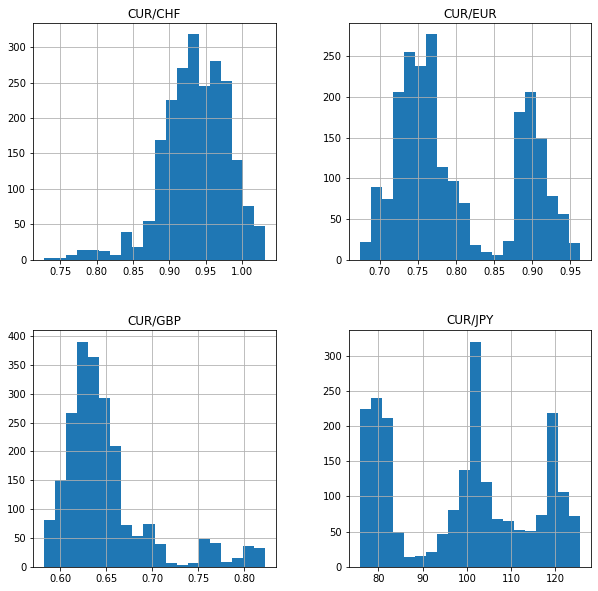

In [37]:
FX_DF.hist(bins=20, figsize=(10,10))
plt.show()

### Working with Equities

In [38]:
eq_list = ['EOD/MSFT', 'EOD/AAPL', 'EOD/MMM', 'EOD/MCD']
EQ_DF = pd.DataFrame(index=dates)
for code in eq_list:
    EQ_DF[code] = quandl.get(code, start_date=start, end_date=end_).Close

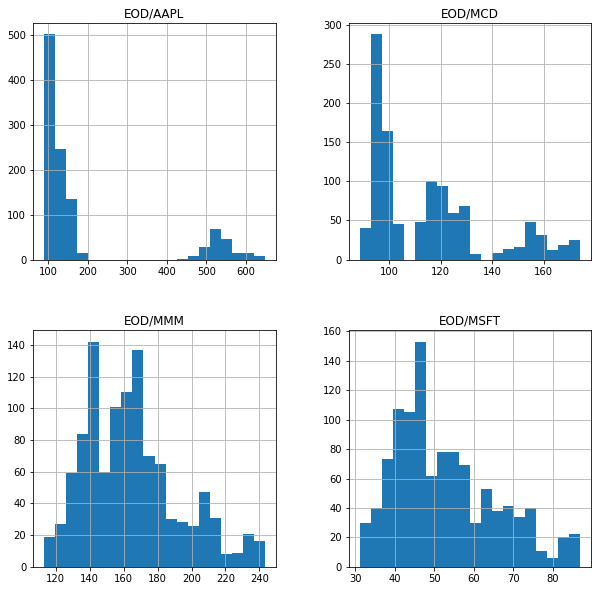

In [39]:
EQ_DF.hist(bins=20, figsize=(10,10))
plt.show()

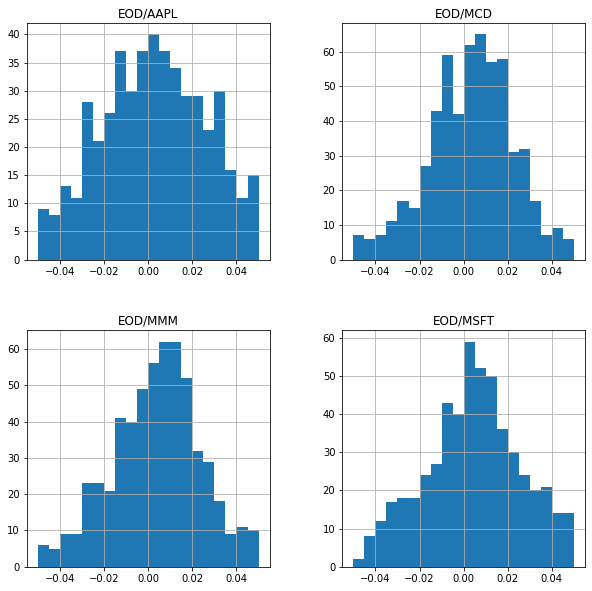

In [40]:
EQ_Returns = (EQ_DF / EQ_DF.shift(10)) - 1
EQ_Returns.hist(bins=20, range=(-0.05, 0.05), figsize=(10,10))
plt.show()

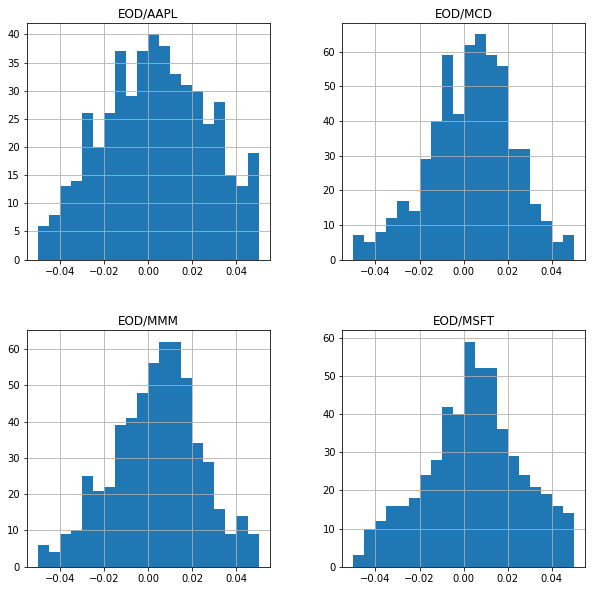

In [41]:
EQ_DF_LogReturns = np.log(EQ_DF / EQ_DF.shift(10))
EQ_DF_LogReturns.hist(bins=20, range=(-0.05, 0.05), figsize=(10,10))
plt.show()

## Value at Risk ##

### Single Asset

There's nothing very complicated about Value at Risk (VAR). To put it simply, it's simply a single metric that shows the potential losses of a portfolio etc (at different confidence levels). There are three main methods to compute VAR -
* Parametric
* Historical
* Monte Carlo

**Parametric VAR**

Very often, the parametric VAR is based on a normal distribution. Plotting a normal distribution and the VAR on a chart will give us a good overview of how this works.

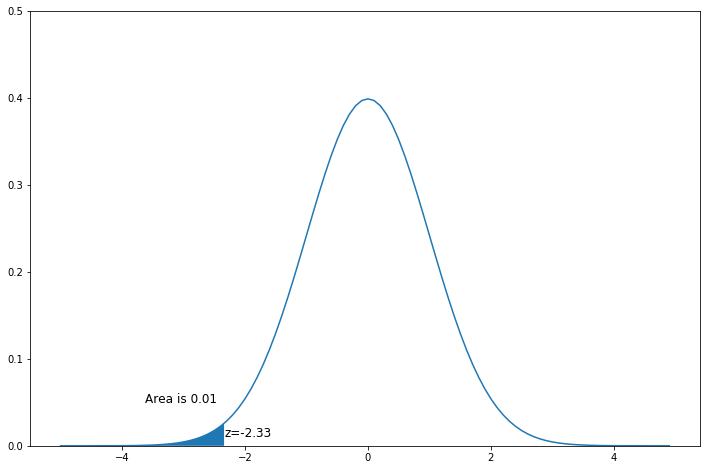

In [42]:
# We use z to define how many standard deviations away from the mean
# Here we use z = -2.33 to get to a 99% confidence interval. Why 99% will be obvious once we plot out the distribution
z = -2.33

plt.figure(figsize=(12,8))

# plotting the normal distribution, using the scipy stats norm function
plt.ylim(0, 0.5)
x = np.arange(-5,5,0.1)
y1 = stats.norm.pdf(x)
plt.plot(x, y1)

x2 = np.arange(-5, z, 0.01) # we use this range from the -ve end to -2.33 to compute the area
sum_ = 0
# s = np.arange(-10,z,0.01)
for i in x2:
    sum_ += stats.norm.pdf(i) * 0.01 # computing area under graph from -5 to -2.33 in steps of 0.01

plt.annotate('Area is ' + str(round(sum_,3)), xy = (z-1.3, 0.05), fontsize=12)
plt.annotate('z=' + str(z), xy=(z, 0.01), fontsize=12)
plt.fill_between(x2, stats.norm.pdf(x2))
plt.show()

Once you understand what VAR and confidence levels mean (from the chart above), getting the $Z$ for different confidence levels is simple, and is the basis for computing parametric VAR.

In [43]:
z_95 = stats.norm.ppf(1 - 0.95)
z_99 = stats.norm.ppf(1 - 0.99)
z_999 = stats.norm.ppf(1 - 0.999)

print('95%, 99%, 99.9% Z =', z_95, z_99, z_999)

95%, 99%, 99.9% Z = -1.6448536269514722 -2.3263478740408408 -3.090232306167813


Let $\alpha$ be the confidence level, then the $N$-day VaR is given by:
> $VAR_N = \varPhi^{-1}(1-\alpha) * \sigma_V * \sqrt{N}$

If we are working with returns, then the formula becomes:
> $VAR_N = position * (-\mu_V + \varPhi^{-1}(1-\alpha)*\sigma_V) * \sqrt{N}$

If mean return is close 0, then we can drop this term from the formula above.

In [44]:
import datetime

start = pd.datetime(2011,1,1)
end_ = pd.datetime.today()

In [45]:
# Get Price data from AAPL
AAPL = quandl.get('EOD/AAPL', start_date=start, end_date=end_).Close

rets_1 = (AAPL / AAPL.shift(1)) - 1

First, let’s get market prices of AAPL from Quandl again, and compute the returns.
We shall compute the mean and standard deviation of the AAPL returns first as we will use this later to perform Monte Carlo simulation.

In [46]:
mean = np.mean(rets_1)
std = np.std(rets_1)
Z_99 = stats.norm.ppf(1 - 0.99)
price = AAPL.iloc[-1]

print(mean, std, Z_99, price)

0.00012614513280729436 0.02959836345294892 -2.3263478740408408 171.08


Now, let’s compute the parametric and historical VAR numbers so we have a basis for comparison.

In [47]:
ParamVAR = price * Z_99 * std

**Historical VaR**

Historical VAR is even simpler. We simply get the return at the right percentile and apply the same formula to the latest prices.

In [48]:
HistVAR = price * np.percentile(rets_1.dropna(), 1)

print('Parametric VAR is {0:.3f} and Historical VAR is {1:.3f}'.format(ParamVAR, HistVAR))

Parametric VAR is -11.780 and Historical VAR is -6.704


**Monte Carlo**

For Monte Carlo simulation, we simply apply a simulation using the assumptions of normality, and the mean and std computed above.

In [49]:
np.random.seed(100)
n_sims = 1000000
sim_returns = np.random.normal(mean, std, n_sims)
SimVAR = price * np.percentile(sim_returns, 1)
print('Simulated VAR is ', SimVAR)

Simulated VAR is  -11.725602014919927


### Multiple Assets

**Parametric VAR**

Let's compute the VAR for the equity prices we obtained from Quandl earlier

In [50]:
confidence = 0.99
Z = stats.norm.ppf(1 - confidence)
mean = np.mean(EQ_Returns)
stddev = np.std(EQ_Returns)

The VAR for the latest prices is then ...

In [51]:
EQ_DF.dropna().iloc[-1,:] * Z *stddev

EOD/MSFT    -6.856038
EOD/AAPL   -31.625073
EOD/MMM    -14.430516
EOD/MCD     -9.489010
dtype: float64

**Historical VAR**

In [52]:
print(EQ_DF.dropna().iloc[-1,:] * np.percentile(EQ_Returns.dropna(), 1))

EOD/MSFT    -6.990010
EOD/AAPL   -13.950664
EOD/MMM    -19.221713
EOD/MCD    -14.115385
Name: 2017-12-28 00:00:00, dtype: float64
